Looking for the most likely cause of the decrease in Nea. % over the last 10 thousand years.

This is the time period for which we have 6 higher coverage EMHs, all from around 8 kya.

Main idea - if we restrict to super-neutral sites and we see shift in the distribution of Nea. allele frequencies, this is an evidence of migration.

If we see a significant shift at non-neutral sites *beyond* of what is observed on the super-neutral sites, this can be interpreted as selection.

*Why would this work?* After > 40k years after introgression, the individual blocks should be broken down enough so that we can stop worrying about linkage so much. We can therefore have a better idea of which SNPs are super-neutral, compared to early EMHs where, due to longer haplotypes, filtering for superneutral SNPs is problematic (i.e. how far from the informative site we want to filter potential conserved regions?)

**TODO:** Calculate the expected length of Nea. haplotype over time to justify this. (_"One of the issues with modelling selection against Nea. alleles is the fact that at the time of introgression they introgressed on shared haplotypes. Therefore, the process of selection against Nea. alleles cannot be modeled under an assumption of independent sites, for example using a diffusion approximation method. Moreover, as the length of Nea. haplotypes decays over time, the linkage between these alleles is decreasing, until, at some point, each Nea. haplotype carries approximately only single allele. To circumvent the issue, we focused on samples younger than ~8kya, which is the time point at which it is reasonable to assume that most of the Nea. deleterious alleles are segregating independently of each other."_)

**TODO**: Would it make sense to use the BAM files of the later EMHs and aggregate all the available reads to have a better idea of the actual Nea. introgressed allele frequencies or would it be too much effort?

**TODO**: Make sure to use only sites for which you have sites available from all later EMHs?

In [131]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../R/utils.R")

In [132]:
files <- list.files("../clean_data/annotations/", pattern="priPhCons__100000bp.bed", full.names=TRUE)

window_avgs_long <- lapply(files, function(f) {
    read.table(f, header=FALSE) %>%
        .[1:4] %>%
        setNames(c("chrom", "start", "end", "value")) %>%
        mutate(track=str_replace(basename(f), ".bed", ""))
}) %>%
    bind_rows %>%
    rename(pos=end) %>% 
    select(-start)

window_avgs_wide <- spread(window_avgs_long, track, value)

In [133]:
suppressMessages(
    cadd_wide <-
        load_annotations("../clean_data/annotations.tsv") %>%
        select(chrom, pos, bStatistic, Consequence, AnnoType)
)

Warning message:
“673 parsing failures.
row # A tibble: 5 x 4 col     row            col               expected  actual expected   <int>          <chr>                  <chr>   <chr> actual 1  2136 mapAbility35bp no trailing characters      .5 row 2  4607 mapAbility35bp no trailing characters .333333 col 3  5028 mapAbility35bp no trailing characters      .5 expected 4  5379 mapAbility35bp no trailing characters      .5 actual 5  5819 mapAbility35bp no trailing characters      .5
... ................. ... ..................................................... ........ ..................................................... ...... ..................................................... ... ..................................................... ... ..................................................... ........ ..................................................... ...... .....................................................
See problems(...) for more details.
”

In [134]:
all_annots_wide <- inner_join(window_avgs_wide, cadd_wide)

Joining, by = c("chrom", "pos")


In [135]:
colnames(all_annots_wide)[3:ncol(all_annots_wide)]

[1] "priPhCons__100000bp" "bStatistic"          "Consequence"        
[4] "AnnoType"

In [136]:
table(all_annots_wide$AnnoType)


   CodingTranscript          Intergenic NonCodingTranscript   RegulatoryFeature 
               8275              440179                8398              100604 
         Transcript 
             387901 

In [80]:
table(all_annots_wide$Consequence)


      3PRIME_UTR       5PRIME_UTR CANONICAL_SPLICE       DOWNSTREAM 
            5084              320               75            60703 
      INTERGENIC         INTRONIC   NON_SYNONYMOUS NONCODING_CHANGE 
          323239           381629             4048             8322 
      REGULATORY      SPLICE_SITE      STOP_GAINED        STOP_LOST 
          100604              964               39                7 
      SYNONYMOUS         UPSTREAM 
            4086            56237 

In [81]:
filter(all_annots_wide, AnnoType == "Intergenic") %>% .[["Consequence"]] %>% table

.
DOWNSTREAM INTERGENIC   UPSTREAM 
     60703     323239      56237 

In [82]:
filter(all_annots_wide, AnnoType == "CodingTranscript") %>% .[["Consequence"]] %>% table

.
NON_SYNONYMOUS    SPLICE_SITE    STOP_GAINED      STOP_LOST     SYNONYMOUS 
          4048             95             39              7           4086 

In [83]:
filter(all_annots_wide, AnnoType == "RegulatoryFeature") %>% .[["Consequence"]] %>% table

.
REGULATORY 
    100604 

In [137]:
# read processed SNP tables of aDNA samples and SGDP individuals,
# merge them and intersect them with the annotations data
all_snps <- load_dataset("../clean_data/ice_age.tsv",
                         "../clean_data/sgdp.tsv",
                         "../clean_data/archaics.tsv",
                         filter_damage=FALSE,
                         metadata_path="../raw_data/10_24_2014_SGDP_metainformation_update.txt",
                         random_sample=T)

emh_info <- # filter out high C-T samples (mainly non-UDG treated ones and weird library preps)
  read_delim("../clean_data/ages.txt", delim=" ") %>%
  mutate(pop="EMH_Europe") %>%
  filter(name %in% colnames(all_snps),
         ! name %in% c("AfontovaGora3", "GoyetQ116_1", "Kotias", "Oase1", "Satsurblia", "Villabruna")) %>%
  filter(age < 10000)
  

# process the SGDP metainformation table
sgdp_info <-
  load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
  mutate(name=str_replace(name, "^S_", "")) %>%
  filter(name %in% colnames(all_snps)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(pop == "WestEurasia") %>%
  mutate(pop="present_Europe") %>% 
  filter(! Country %in% c('Iran', 'Iraq', 'Jordan', 'Israel(Central)',
                          'Israel(Carmel)', 'Israel(Negev)', 'Israel', 'Tajikistan', 'Turkey', 'Yemen',
                          'Abkhazia', 'Armenia')) #%>% 
  #sample_n(size=nrow(emh_info))

samples_info <-
  bind_rows(emh_info, sgdp_info) %>%
  mutate(post_admixture=55000 - age)

Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Parsed with column specification:
cols(
  .default = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  Coverage = col_integer(),
  HetRateAuto = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_integer(),
  ref = col_character(),
  alt = col_character()
)
See spec(...) for full column specifications.
Warning message:
“Unknown variables: `S_Australian_1`, `S_Australian_5`”Parsed with column specification:
cols(
  chrom = col_integer(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character(),
  Altai = col_integer(),


In [138]:
nrow(all_snps)

[1] 484016

In [139]:
samples_info %>% group_by(pop) %>% count()

pop,n
EMH_Europe,6
present_Europe,43


In [140]:
select(filter(samples_info, pop == "EMH_Europe"), name, age, pop)

name,age,pop
Karelia,8375,EMH_Europe
Loschbour,8050,EMH_Europe
LaBrana1,7815,EMH_Europe
Hungarian_KO1,7660,EMH_Europe
Motala12,7625,EMH_Europe
Stuttgart,7140,EMH_Europe


In [141]:
select(filter(samples_info, pop == "present_Europe"), name, age, pop, Country)$name

[1] "Abkhasian_2"      "Adygei_1"         "Adygei_2"         "Albanian_1"      
 [5] "Basque_1"         "Basque_2"         "Bergamo_2"        "Bulgarian_1"     
 [9] "Bulgarian_2"      "Chechen_1"        "Czech_2"          "English_1"       
[13] "English_2"        "Estonian_1"       "Estonian_2"       "Finnish_1"       
[17] "Finnish_2"        "Finnish_3"        "French_1"         "French_2"        
[21] "Georgian_1"       "Georgian_2"       "Greek_1"          "Greek_2"         
[25] "Hungarian_1"      "Hungarian_2"      "Icelandic_1"      "Icelandic_2"     
[29] "Lezgin_1"         "Lezgin_2"         "North_Ossetian_1" "North_Ossetian_2"
[33] "Orcadian_1"       "Orcadian_2"       "Polish_1"         "Russian_1"       
[37] "Russian_2"        "Sardinian_1"      "Sardinian_2"      "Spanish_1"       
[41] "Spanish_2"        "Tuscan_1"         "Tuscan_2"

Filter SNPs for early/present-day  European samples only:

In [12]:
eur_snps <- select(all_snps, c(chrom, pos, one_of(as.character(samples_info$name))))

In [13]:
head(eur_snps)

chrom,pos,Karelia,Loschbour,LaBrana1,Hungarian_KO1,Motala12,Stuttgart,Spanish_2,Spanish_1,Finnish_3,Bulgarian_2,Orcadian_1,Bergamo_2
1,847983,0,0,0,0,0,0,0,0,0,0,0,0
1,853089,0,0,0,NA,0,0,0,0,0,0,0,0
1,853596,NA,0,0,NA,NA,0,0,0,0,0,0,0
1,854793,0,0,0,NA,0,0,0,0,0,0,0,0
1,867552,0,0,0,NA,0,0,0,0,0,0,0,0
1,871401,NA,0,0,NA,0,0,0,0,0,0,0,0


#### What are the counts of missing sites in the EMH data?

In [14]:
select(eur_snps, Karelia:Stuttgart) %>% apply(1, function(r) sum(is.na(r))) %>% as.vector %>% table

.
     0      1      2      3      4      5      6 
155614 200980  95373  25168   4010    428   2443 

#### What is the missing SNP rate in the individual samples?

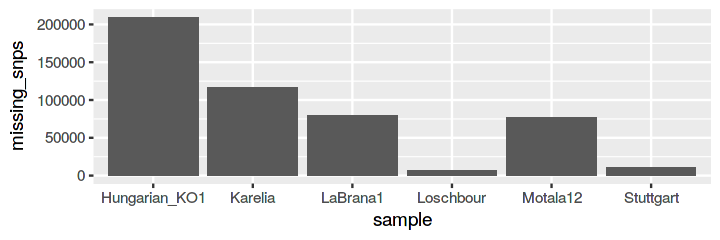

In [15]:
options(repr.plot.width=6, repr.plot.height=2)

select(eur_snps, Karelia:Stuttgart) %>%
summarise_all(function(i) sum(is.na(i))) %>%
gather(sample, missing_snps) %>% 
ggplot(aes(sample, missing_snps)) + geom_bar(stat="identity")

#### What are the counts of missing sites in the present-day data?

In [16]:
select(eur_snps, 9:ncol(eur_snps)) %>% apply(1, function(r) sum(is.na(r))) %>% table

.
     0      1      2      3      4      5      6 
483543    291     92     41     24     18      7 

#### Filter for sites with information from all individuals

In [17]:
na_counts <- apply(eur_snps[3:ncol(eur_snps)], 1, function(r) sum(is.na(r)))

In [18]:
eur_snps <- eur_snps[na_counts == 0, ]

In [19]:
nrow(eur_snps) 

[1] 155569

Create a lookup table of sample population assignments:

In [20]:
pop_table <- samples_info$pop
names(pop_table) <- samples_info$name

Merge annotations with SNP data and convert the DF into a long format:

In [21]:
merged <-
    inner_join(all_annots_wide, eur_snps) %>% # merge annotations with SNP data
    mutate(chrom=paste0(chrom, "_", pos)) %>% # create a SNP ID string
    rename(site_id=chrom) %>%  select(-pos)   # remove the chrom/pos columns

Joining, by = c("chrom", "pos")


In [22]:
head(merged)

site_id,priPhCons__100000bp,bStatistic,Consequence,AnnoType,Karelia,Loschbour,LaBrana1,Hungarian_KO1,Motala12,Stuttgart,Spanish_2,Spanish_1,Finnish_3,Bulgarian_2,Orcadian_1,Bergamo_2
1_847983,0.047667,958,NONCODING_CHANGE,NonCodingTranscript,0,0,0,0,0,0,0,0,0,0,0,0
1_1131600,0.031456,873,INTRONIC,Transcript,0,0,0,0,0,0,0,0,0,0,0,0
1_1193746,0.040323,769,REGULATORY,RegulatoryFeature,0,0,0,0,0,0,0,0,0,0,0,0
1_1195565,0.040551,779,REGULATORY,RegulatoryFeature,0,0,0,0,0,0,0,0,0,0,0,0
1_1200468,0.045850,784,REGULATORY,RegulatoryFeature,0,0,0,0,0,0,0,0,0,0,0,0
1_1696390,0.055556,662,INTRONIC,Transcript,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
sites <-
    gather(merged, name, allele, -site_id, -AnnoType, -Consequence, -priPhCons__100000bp, -bStatistic) %>%
    mutate(pop=pop_table[name],
           allele=ifelse(allele == 2, 1, 0))
           #allele=ifelse(allele == 0, 0, ifelse(allele == 1, 0.5, ifelse(allele == 2, 1, NA))))

In [24]:
head(sites)

site_id,priPhCons__100000bp,bStatistic,Consequence,AnnoType,name,allele,pop
1_847983,0.047667,958,NONCODING_CHANGE,NonCodingTranscript,Karelia,0,EMH_Europe
1_1131600,0.031456,873,INTRONIC,Transcript,Karelia,0,EMH_Europe
1_1193746,0.040323,769,REGULATORY,RegulatoryFeature,Karelia,0,EMH_Europe
1_1195565,0.040551,779,REGULATORY,RegulatoryFeature,Karelia,0,EMH_Europe
1_1200468,0.045850,784,REGULATORY,RegulatoryFeature,Karelia,0,EMH_Europe
1_1696390,0.055556,662,INTRONIC,Transcript,Karelia,0,EMH_Europe


In [25]:
str(sites)

'data.frame':	1866828 obs. of  8 variables:
 $ site_id            : chr  "1_847983" "1_1131600" "1_1193746" "1_1195565" ...
 $ priPhCons__100000bp: num  0.0477 0.0315 0.0403 0.0406 0.0459 ...
 $ bStatistic         : int  958 873 769 779 784 662 653 682 716 774 ...
 $ Consequence        : chr  "NONCODING_CHANGE" "INTRONIC" "REGULATORY" "REGULATORY" ...
 $ AnnoType           : chr  "NonCodingTranscript" "Transcript" "RegulatoryFeature" "RegulatoryFeature" ...
 $ name               : chr  "Karelia" "Karelia" "Karelia" "Karelia" ...
 $ allele             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ pop                : Named chr  "EMH_Europe" "EMH_Europe" "EMH_Europe" "EMH_Europe" ...
  ..- attr(*, "names")= chr  "Karelia" "Karelia" "Karelia" "Karelia" ...


Calculate the SFS of introgressed alleles at each available time point

In [26]:
sfs <- group_by(sites, pop, site_id, AnnoType, priPhCons__100000bp, bStatistic) %>%
    summarise(f=mean(allele, na.rm=TRUE)) %>% 
    #summarise(f=mean(0.5 * allele)) %>% -- this is for the case of 0/1/2 alleles
    #summarise(f=mean(allele), na.rm=TRUE) %>% -- not necessary after filtering out NA before, also no random calls
    # filter(!is.nan(f)) %>% -- not necessary either
    ungroup

In [27]:
head(sfs)

pop,site_id,AnnoType,priPhCons__100000bp,bStatistic,f
EMH_Europe,1_100002713,Intergenic,0.112185,815,0
EMH_Europe,1_100030862,Intergenic,0.120319,857,0
EMH_Europe,1_100075381,Intergenic,0.129699,813,0
EMH_Europe,1_100101335,Intergenic,0.135984,757,0
EMH_Europe,1_100102248,Intergenic,0.136405,753,0
EMH_Europe,1_100105433,Intergenic,0.141346,759,0


# Results using just the overlapping sites

In [28]:
options(repr.plot.widht=6, repr.plot.height=4)

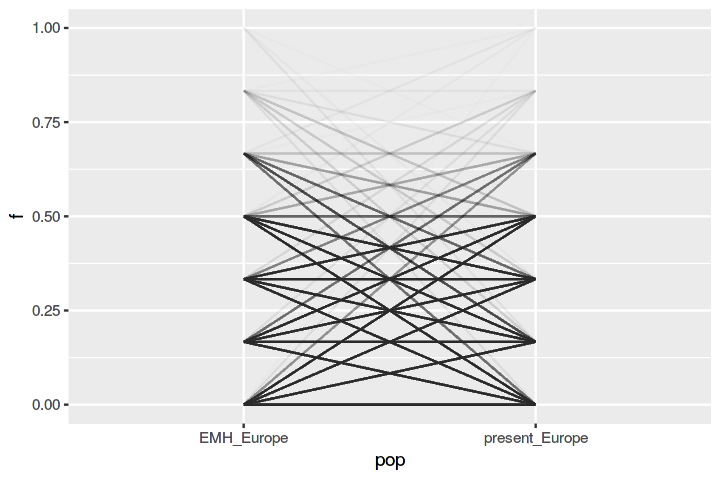

In [29]:
ggplot(sfs, aes(pop, f, group=site_id)) + geom_line(alpha=0.01) + ylim(0, 1)

Mean of the SFS of Nea. alleles in both populations:

In [30]:
group_by(sfs, pop) %>% summarise(mean(f, na.rm=TRUE))

pop,"mean(f, na.rm = TRUE)"
EMH_Europe,0.02162277
present_Europe,0.01829092


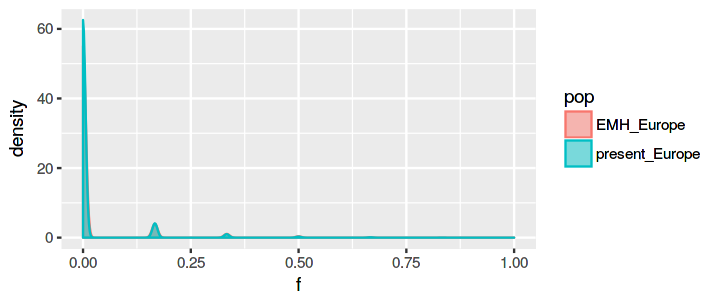

In [31]:
options(repr.plot.widht=8, repr.plot.height=2.5)
ggplot(sfs, aes(f, fill=pop, color=pop)) + geom_density(alpha=1/2) + xlim(0, 1)

Calculate the shift in Nea. allele frequencies between EMH and present-day Europeans:

In [32]:
sfs_shift <-
    spread(sfs, pop, f) %>%
    mutate(freq_shift=present_Europe - EMH_Europe)

## Genome annotation - coding/regulatory/intergenic

In [33]:
options(repr.plot.width=7, repr.plot.height=4)

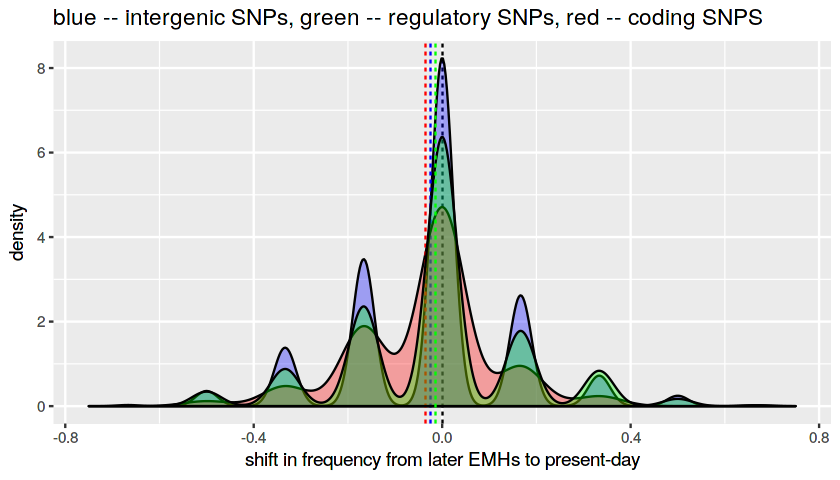

In [34]:
seg_in_emh <- filter(sfs_shift, EMH_Europe > 0, EMH_Europe < 1, present_Europe > 0, present_Europe < 1)

ggplot() +
    geom_vline(xintercept=0, linetype=2, color="black") +

    geom_density(data=filter(seg_in_emh, AnnoType == "Intergenic"), aes(freq_shift), alpha=1/3, fill="blue") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "Intergenic")$freq_shift), linetype=2, color="blue") +

    geom_density(data=filter(seg_in_emh, AnnoType == "CodingTranscript"), aes(freq_shift), alpha=1/3, fill="red") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "CodingTranscript")$freq_shift), linetype=2, color="red") +

    geom_density(data=filter(seg_in_emh, AnnoType == "RegulatoryFeature"), aes(freq_shift), alpha=1/3, fill="green") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "RegulatoryFeature")$freq_shift), linetype=2, color="green") +

    xlab("shift in frequency from later EMHs to present-day") +
    ggtitle("blue -- intergenic SNPs, green -- regulatory SNPs, red -- coding SNPS") +
    xlim(-0.75, 0.75)

In [35]:
summary(seg_in_emh$freq_shift)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.66670 -0.16670  0.00000 -0.02098  0.00000  0.66670 

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(stringr)
    library(magrittr)
})

source("../R/utils.R")

In [2]:
if (! file.exists("../tmp/freq_shift.RData")) {

suppressWarnings(suppressMessages({
    

########################################
# read annotation data
#
files <- list.files("../clean_data/annotations/", pattern="priPhCons__100000bp.bed", full.names=TRUE)

window_avgs_long <- lapply(files, function(f) {
    read.table(f, header=FALSE) %>%
        .[1:4] %>%
        setNames(c("chrom", "start", "end", "value")) %>%
        mutate(track=str_replace(basename(f), ".bed", ""))
}) %>%
    bind_rows %>%
    rename(pos=end) %>% 
    select(-start)

window_avgs_wide <- spread(window_avgs_long, track, value)

cadd_wide <-
    load_annotations("../clean_data/annotations.tsv") %>%
    select(chrom, pos, bStatistic, Consequence, AnnoType)

all_annots_wide <- inner_join(window_avgs_wide, cadd_wide)


########################################
# read processed aDNA/SGDP SNP tables
all_snps <- load_dataset("../clean_data/ice_age.tsv",
                         "../clean_data/sgdp.tsv",
                         "../clean_data/archaics.tsv",
                         filter_damage=FALSE,
                         metadata_path="../raw_data/10_24_2014_SGDP_metainformation_update.txt",
                         random_sample=T)
    

########################################
# read sample info tables

# EMH info
emh_info <- # filter out high C-T samples (mainly non-UDG treated ones and weird library preps)
  read_delim("../clean_data/ages.txt", delim=" ") %>%
  mutate(pop="EMH_Europe") %>%
  filter(name %in% colnames(all_snps),
         ! name %in% c("AfontovaGora3", "GoyetQ116_1", "Kotias", "Oase1", "Satsurblia", "Villabruna")) %>%
  filter(age < 10000)
  

# SGDP info
sgdp_info <-
  load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
  mutate(name=str_replace(name, "^S_", "")) %>%
  filter(name %in% colnames(all_snps)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(pop == "WestEurasia") %>%
  mutate(pop="present_Europe") %>% 
  filter(! Country %in% c('Iran', 'Iraq', 'Jordan', 'Israel(Central)',
                          'Israel(Carmel)', 'Israel(Negev)', 'Israel', 'Tajikistan', 'Turkey', 'Yemen',
                          'Abkhazia', 'Armenia')) #%>% 
  #sample_n(size=nrow(emh_info))

# merge SGDP and EMH info
samples_info <-
  bind_rows(emh_info, sgdp_info) %>%
  mutate(post_admixture=55000 - age)


# get only sites where all European samples have a base
eur_snps <- select(all_snps, c(chrom, pos, one_of(as.character(samples_info$name))))
na_counts <- apply(eur_snps[3:ncol(eur_snps)], 1, function(r) sum(is.na(r)))
eur_snps <- eur_snps[na_counts == 0, ]

}))


########################################
# save the objects to a file
save(all_annots_wide, eur_snps, samples_info, file="../tmp/freq_shift.RData")

}

load("../tmp/freq_shift.RData")

In [3]:
nrow(eur_snps)

[1] 155421

In [125]:
n_bins <- 10
cutoffs <- quantile(all_annots_wide$bStatistic,
             prob=seq(0, 1, length.out=n_bins + 1),
             na.rm=TRUE)
all_annots_wide %<>% mutate(bStatistic=findInterval(bStatistic, vec=cutoffs,
                            rightmost.closed=TRUE))

In [126]:
head(all_annots_wide)

chrom,pos,priPhCons__100000bp,bStatistic,Consequence,AnnoType
1,847983,0.047667,9,NONCODING_CHANGE,NonCodingTranscript
1,853089,0.049807,9,NONCODING_CHANGE,NonCodingTranscript
1,853596,0.049866,9,NONCODING_CHANGE,NonCodingTranscript
1,854793,0.049938,9,NONCODING_CHANGE,NonCodingTranscript
1,858862,0.051017,8,REGULATORY,RegulatoryFeature
1,867151,0.047507,8,UPSTREAM,Intergenic


In [4]:
# subsample SGDP individual to have the same number as the number
# of EMHs
subsample_individuals <- function(all_samples, samples_info) {
    # get the names of EMHs
    emh_samples <- samples_info[samples_info$pop == "EMH_Europe", ]$name
    # subsample the names of SGDP individuals
    sgdp_samples <- samples_info[samples_info$pop == "present_Europe", ]$name
    sgdp_subsample <- sample(sgdp_samples, length(emh_samples))

    # return the SNP table of just the sampled individuals
    all_samples[, c("chrom", "pos", emh_samples, sgdp_subsample)]
}

In [202]:
# calculate the frequencies of Nea-like SNPs at each overlapping
# site in each of the two populations
calc_sfs <- function(snps) {
    # create a pop-assignment table
    pop_table <- samples_info$pop
    names(pop_table) <- samples_info$name

    # convert wide format SNP table to a long format, assign each
    # sample to a population and convert allele info from 2/0 to 1/0
    sites <-
        gather(snps, name, allele, -chrom, -pos) %>%
        mutate(name=str_replace(name, "_xyz_[0-9]+$", ""), # remove the name suffix
               pop=pop_table[name],                     # look up the population assignment
               allele=ifelse(allele == 2, 1, 0))

    # calculate the SFS on the subsampled EMH and SGDP populations
    sfs <-
        group_by(sites, pop, chrom, pos) %>%
        summarise(f=mean(allele, na.rm=TRUE)) %>% 
        ungroup
    
    sfs
}


# calculate shift in allele frequencies at each site between EMH
# and present-day Europeans
calc_sfs_shift <- function(sfs) {
    sfs_shift <-
        spread(sfs, pop, f) %>%
        mutate(freq_shift=present_Europe - EMH_Europe)

    sfs_shift
}
                       
                       
plot_dist <- function(sfs) {
    options(repr.plot.width=5, repr.plot.height=3)

    sfs <- filter(sfs, EMH_Europe > 0, EMH_Europe < 1, present_Europe > 0, present_Europe < 1)

    ggplot() +
        geom_vline(xintercept=0, linetype=2, color="black") +

        geom_density(data=filter(sfs, AnnoType == "Intergenic"), aes(freq_shift), alpha=1/3, fill="blue") +
        geom_vline(xintercept=mean(filter(sfs, AnnoType == "Intergenic")$freq_shift), linetype=2, color="blue") +

        geom_density(data=filter(sfs, AnnoType == "CodingTranscript"), aes(freq_shift), alpha=1/3, fill="red") +
        geom_vline(xintercept=mean(filter(sfs, AnnoType == "CodingTranscript")$freq_shift), linetype=2, color="red") +

        geom_density(data=filter(sfs, AnnoType == "RegulatoryFeature"), aes(freq_shift), alpha=1/3, fill="green") +
        geom_vline(xintercept=mean(filter(sfs, AnnoType == "RegulatoryFeature")$freq_shift), linetype=2, color="green") +

        xlab("shift in frequency from later EMHs to present-day") +
        ggtitle("blue -- intergenic SNPs, green -- regulatory SNPs, red -- coding SNPS")
}

plot_shift <- function(sfs) {
    options(repr.plot.width=5, repr.plot.height=3)

    ggplot() +
        geom_vline(xintercept=0, linetype=2, color="black") +

        geom_density(data=sfs, aes(freq_shift), alpha=1/3, fill="blue") +
        geom_vline(xintercept=mean(sfs$freq_shift), linetype=2, color="blue") +

        xlab("shift in frequency of neutral SNPs from later EMHs to present-day")
}

In [249]:
library(parallel)

In [250]:
n_iter <- 100

In [258]:
shift_iters <-
    mclapply(seq(n_iter),
             function(i) {
                 subsample_individuals(eur_snps, samples_info) %>%
                 calc_sfs %>%
                 calc_sfs_shift %>%
                 filter(EMH_Europe > 0, EMH_Europe < 1, present_Europe > 0, present_Europe < 1) %>%
                 select(-EMH_Europe, -present_Europe) %>%
                 left_join(all_annots_wide, by=c("chrom", "pos")) %>% 
                 mutate(iter=i)
             },
             mc.cores=50) %>%
    bind_rows

In [252]:
head(shift_iters)

chrom,pos,EMH_Europe,present_Europe,freq_shift,priPhCons__100000bp,bStatistic,Consequence,AnnoType,iter
1,847983,0,0,0,0.047667000000000001037,9,NONCODING_CHANGE,NonCodingTranscript,1
1,1131600,0,0,0,0.031455999999999997851,5,INTRONIC,Transcript,1
1,1193746,0,0,0,0.040322999999999997733,3,REGULATORY,RegulatoryFeature,1
1,1195565,0,0,0,0.040550999999999996770,4,REGULATORY,RegulatoryFeature,1
1,1200468,0,0,0,0.045850000000000001865,4,REGULATORY,RegulatoryFeature,1
1,1696390,0,0,0,0.055556000000000001215,2,INTRONIC,Transcript,1


#### Mean Nea in a population

all

In [255]:
shift_iters %>% 
    group_by(iter) %>%
    summarise(emh=mean(EMH_Europe), pres=mean(present_Europe)) %>%
    summarise(emh=mean(emh), pres=mean(pres)) %>%
    mutate(change=1 - pres / emh)

emh,pres,change
0.021652,0.018124,0.16293


intergenic sites only

In [256]:
filter(shift_iters, Consequence == "INTERGENIC") %>%
    group_by(iter) %>%
    summarise(emh=mean(EMH_Europe), pres=mean(present_Europe)) %>%
    summarise(emh=mean(emh), pres=mean(pres)) %>%
    mutate(change=1 - pres / emh)

emh,pres,change
0.02087,0.0181,0.13275


In [164]:
b_res <- lapply(1:10, function(i) {
    filter(shift_iters, bStatistic == i) %>%
        group_by(iter) %>%
        summarise(emh=mean(EMH_Europe), pres=mean(present_Europe)) %>%
        summarise(emh=mean(emh), pres=mean(pres)) %>%
        mutate(ratio=pres / emh)
    }) %>% bind_rows %>% mutate(bin=1:10)
b_res

emh,pres,ratio,bin
0.02228773,0.01528485,0.6857966,1
0.01950662,0.01543866,0.7914575,2
0.02052402,0.01576814,0.7682776,3
0.02066458,0.01797181,0.8696914,4
0.01983977,0.01795241,0.9048702,5
0.02078002,0.01839086,0.8850263,6
0.02169389,0.01926026,0.8878198,7
0.02449371,0.01986601,0.8110661,8
0.02149120,0.02038351,0.9484583,9
0.02568669,0.02267336,0.8826889,10


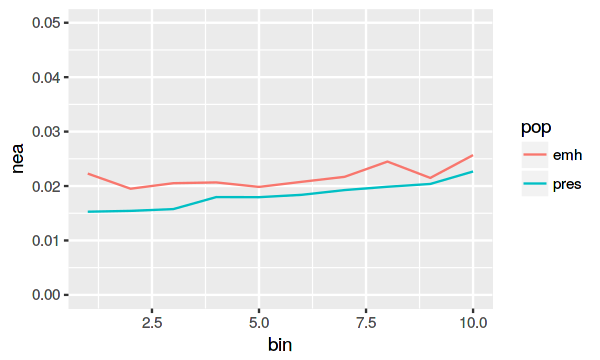

In [165]:
gather(b_res, pop, nea, -ratio, -bin) %>% ggplot(aes(bin, nea, color=pop)) + geom_line() + ylim(0, 0.05)

In [257]:
group_by(shift_iters, chrom, pos) %>%
    summarise(freq_shift=mean(freq_shift)) %>% .[["freq_shift"]] %>% mean

[1] -0.0035278

In [198]:
head(shift_iters)

chrom,pos,EMH_Europe,present_Europe,freq_shift,priPhCons__100000bp,bStatistic,Consequence,AnnoType,iter
1,847983,0,0,0,0.047667,9,NONCODING_CHANGE,NonCodingTranscript,1
1,1131600,0,0,0,0.031456,5,INTRONIC,Transcript,1
1,1193746,0,0,0,0.040323,3,REGULATORY,RegulatoryFeature,1
1,1195565,0,0,0,0.040551,4,REGULATORY,RegulatoryFeature,1
1,1200468,0,0,0,0.045850,4,REGULATORY,RegulatoryFeature,1
1,1696390,0,0,0,0.055556,2,INTRONIC,Transcript,1


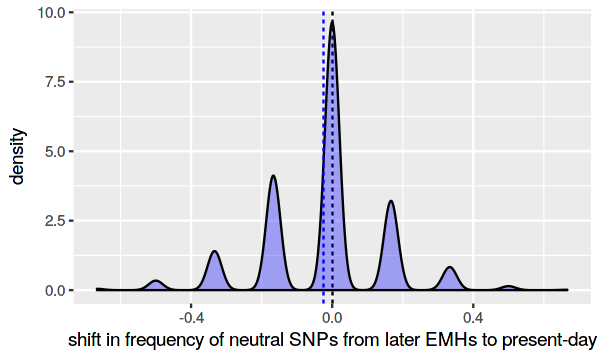

In [264]:
plot_shift(filter(shift_iters, iter == 1))

In [254]:
options(digits=5)

freq_shift,-0.66667,-0.5,-0.33333,-0.16667,0,1.6667e-01,0.33333,0.5,0.66667
n,345.00000,2874.0,11494.00000,32014.00000,84620,2.7070e+04,7277.00000,1574.0,176.00000


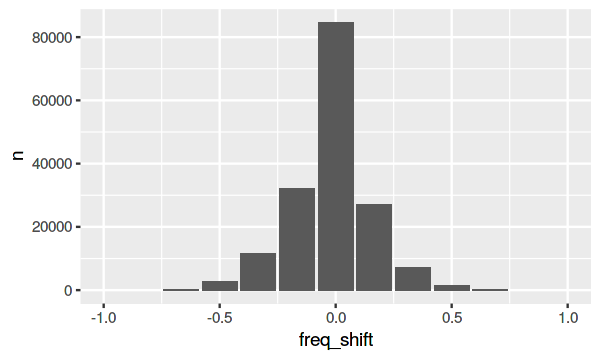

In [268]:
shift_counts <- shift_iters %>%
    filter(Consequence == "INTERGENIC") %>%
    mutate(freq_shift=as.character(freq_shift)) %>% 
    mutate(freq_shift=as.numeric(freq_shift)) %>% 
    group_by(freq_shift) %>%
    summarise(n=n())

t(shift_counts)

options(repr.plot.width=5, repr.plot.height=3)

ggplot(shift_counts) + geom_bar(stat="identity", aes(freq_shift, n)) + xlim(-1, 1)

freq_shift,-0.66667,-0.5,-0.33333,-0.16667,0,1.6667e-01,0.33333,0.5,0.66667
n,203.00000,825.0,3495.00000,11650.00000,31234,1.0014e+04,2644.00000,657.0,99.00000


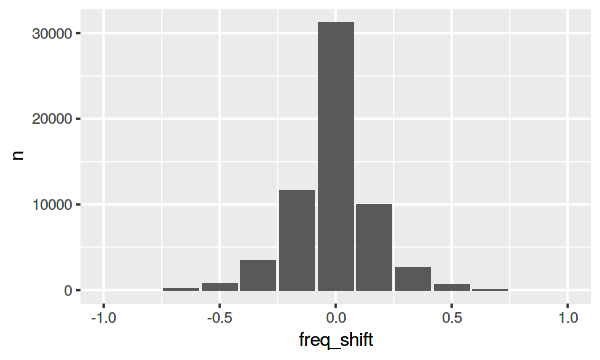

In [269]:
shift_counts <- shift_iters %>%
    filter(bStatistic == 10) %>%
    mutate(freq_shift=as.character(freq_shift)) %>% 
    mutate(freq_shift=as.numeric(freq_shift)) %>% 
    group_by(freq_shift) %>%
    summarise(n=n())

t(shift_counts)

options(repr.plot.width=5, repr.plot.height=3)

ggplot(shift_counts) + geom_bar(stat="identity", aes(freq_shift, n)) + xlim(-1, 1)

freq_shift,-0.66667,-0.5,-0.33333,-0.16667,0,0.16667,0.33333,0.5,0.66667
n,79.00000,569.0,2237.00000,6242.00000,16183,5656.00000,1610.00000,430.0,74.00000


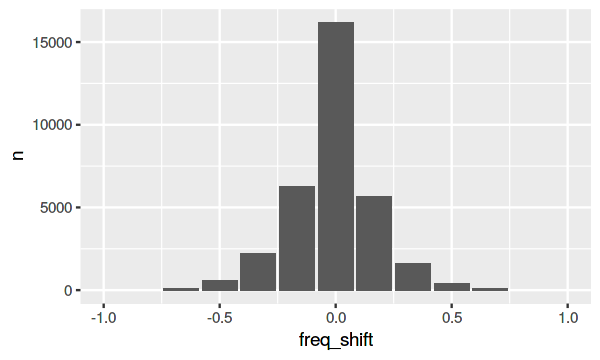

In [272]:
shift_counts <- shift_iters %>%
    filter(priPhCons__100000bp < 0.065532) %>%
    mutate(freq_shift=as.character(freq_shift)) %>% 
    mutate(freq_shift=as.numeric(freq_shift)) %>% 
    group_by(freq_shift) %>%
    summarise(n=n())

t(shift_counts)

options(repr.plot.width=5, repr.plot.height=3)

ggplot(shift_counts) + geom_bar(stat="identity", aes(freq_shift, n)) + xlim(-1, 1)